In [12]:
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import os
import sys

notebook_path = os.path.abspath(".")
sys.path.append(os.path.abspath(os.path.join(notebook_path, '..', 'src')))

import encoding_func

In [9]:
df_modelo = pd.read_pickle('../bin/dataframe_ml.pickle')
df_modelo

,kilometraje,cambio_automatico,potencia,marca_sola,anio_matricula,precio
0,11.652696,True,5.252273,VOLVO,6,10.196194
1,9.615872,True,5.802118,MERCEDES-BENZ,2,11.156251
2,10.512655,True,5.198497,CITROEN,3,10.038936
3,10.238387,False,4.615121,JEEP,2,10.081676
4,12.388398,True,5.484797,JAGUAR,15,8.916104
...,...,...,...,...,...,...
14518,11.643962,True,4.418841,SMART,7,9.158099
14519,11.341128,True,4.812184,TOYOTA,2,10.105653
14520,10.072217,False,4.262680,FIAT,1,9.391912
14521,10.308653,True,5.283204,TOYOTA,1,10.542469


In [10]:
with open(f"../bin/marca_sola_precio_encoder.pickle", "rb") as file:
    marca_sola_precio_encoder = pickle.load(file)

with open(f"../bin/min_max_scaler.pickle", "rb") as file:
    min_max_scaler = pickle.load(file)   

In [11]:
TARGET = "precio"

X_train, X_test, y_train, y_test = encoding_func.dividir_dataframe(df_modelo, TARGET, test_size=0.2, random_state=42)

X_train["marca_sola"] = marca_sola_precio_encoder.transform(X_train["marca_sola"])
X_test["marca_sola"] = marca_sola_precio_encoder.transform(X_test["marca_sola"])

X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)


In [ ]:

def crear_modelo(input_dim):
    """Crea un modelo de red neuronal secuencial para regresión."""
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')  # Una neurona para regresión
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Error cuadrático medio para regresión y MAE como métrica adicional
    return model

def entrenar_modelo(model, X_train, y_train, epochs=100, batch_size=32):
    """Entrena el modelo de red neuronal y guarda el historial de entrenamiento."""
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    return model, history

def obtener_predicciones(model, X_test):
    """Obtiene las predicciones del modelo."""
    return model.predict(X_test).flatten()

def evaluar_modelo(y_test, y_pred):
    """Evalúa el rendimiento del modelo de regresión."""
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

def graficar_historial(history):
    """Grafica el historial de entrenamiento (loss y MAE)."""
    plt.figure(figsize=(12, 5))

    # Gráfica de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica de MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.show()

def main(X_train, X_test, y_train, y_test):
    """Función principal que ejecuta todo el proceso de modelado."""
    model = crear_modelo(X_train.shape[1])
    model, history = entrenar_modelo(model, X_train, y_train)

    y_pred = obtener_predicciones(model, X_test)
    mse, mae, r2 = evaluar_modelo(y_test, y_pred)

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    graficar_historial(history)

/home/bross/Codigo_HAB/PFB_coches/PFB_coches/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1741336803.595467    9750 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
MSE: 0.1074, MAE: 0.2401, R^2: 0.6548


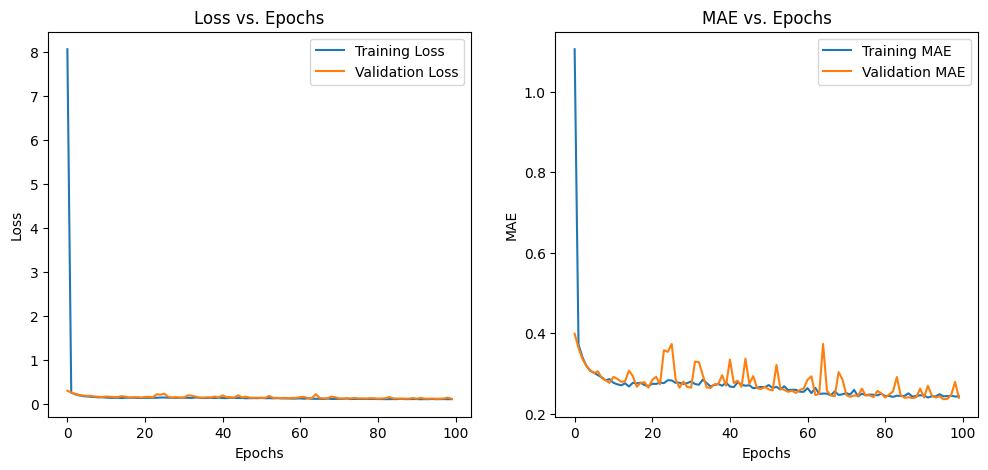

In [14]:
main(X_train, X_test, y_train, y_test)